## Scratchpad

### For implementing model discussed in Geisler, 1984

In [31]:
import numpy as np
import helper_fcns as hf
from scipy.stats import poisson
import autoreload
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pltSave
%matplotlib inline

In [155]:
autoreload.reload(hf);

#### Checking figure 1

In [5]:
s1 = 0.443; s2 = 2.035; # in units of arc minutes
a1 = 0.684; a2 = 0.587;

In [83]:
x_eval = np.linspace(-4.25, 4.25, 100)
lsf_f1 = hf.lsf(x_eval, a1, s1, a2, s2)
lsf_norm = lsf_f1;

Note: Why is the below curve not reaching height of 1? See legend of Fig. 1 for more details/ideas

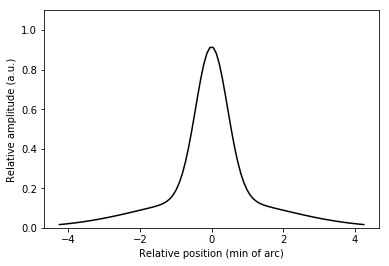

In [84]:
plt.plot(x_eval, lsf_norm, 'k')
plt.ylim(0, 1.10)
plt.xlabel('Relative position (min of arc)')
plt.ylabel('Relative amplitude (a.u.)')

#### Plotting a Poisson distribution

In [71]:
rate1 = 2; # mean number of quanta absorbed
rate2 = 8; # mean number of quanta absorbed
rate3 = 32; # mean number of quanta absorbed
n_absorbed = np.arange(0, 50) # poisson process must have integer evaluations only!

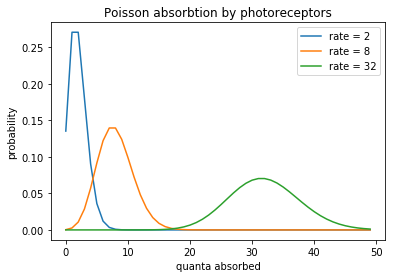

In [79]:
plt.plot(n_absorbed, poisson.pmf(n_absorbed, rate1))
plt.plot(n_absorbed, poisson.pmf(n_absorbed, rate2))
plt.plot(n_absorbed, poisson.pmf(n_absorbed, rate3))
plt.legend(('rate = ' + str(rate1), 'rate = ' + str(rate2), 'rate = ' + str(rate3)))
plt.xlabel('quanta absorbed')
plt.ylabel('probability')
plt.title('Poisson absorbtion by photoreceptors')

#### Point-spread function

Note: In the text, we assume the optics are isotropic, as in same everywhere. Thus, we can assume that the linespread function "generalizes" radially, and thus we use a 2D, radially symmetric gaussian to go from line-spread to point-spread

In [82]:
s1 = 0.443; s2 = 2.035; # in units of arc minutes
a1 = 0.684; a2 = 0.587;

In [144]:
x_eval = np.linspace(-4.25, 4.25, 100)
y_eval = np.linspace(-4.25, 4.25, 100)
xy_eval = np.meshgrid(x_eval, y_eval)
xy_arr = np.asarray(xy_eval);

In [181]:
psf = hf.psf((xy_arr[0], xy_arr[1]), a1, s1, a2, s2);

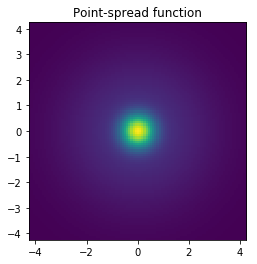

In [186]:
plt.imshow(psf, extent=[np.min(x_eval), np.max(x_eval), np.min(y_eval), np.max(y_eval)], cmap='viridis');
plt.title('Point-spread function - ');

#### Calculating mean absorbtion

In [163]:
# for creating luminance signal - just a point source
lum = 3; # in cd/m2

# for "physical" locations to evaluate
x_min = -4.25;
x_max = 4.25;
y_min = x_min;
y_max = x_max;
n_pts = 101; # should be odd so we get 0 when min/max are symmetric about 0

In [164]:
x_eval = np.linspace(x_min, x_max, n_pts)
y_eval = np.linspace(y_min, y_max, n_pts)
xy_eval = np.meshgrid(x_eval, y_eval)
xy_arr = np.asarray(xy_eval);

We use the same a1/2, s1/2 as above

In [214]:
psf = hf.psf((xy_arr[0], xy_arr[1]), a1, s1, a2, s2);
lum_distr = np.zeros_like(psf)
lum_distr[np.floor(n_pts/2), np.floor(n_pts/2)] = lum
# default: a = 0.28, d = 0.2, s = 3.1416, t = 0.68, e = 0.5
absorb = []; conv2d = [];

absorb_curr, conv2d_curr = hf.absorb(lum_distr, psf); # default
absorb.append(absorb_curr); conv2d.append(conv2d_curr);

absorb_curr, conv2d_curr = hf.absorb(lum_distr, psf, 0.28, 0.5) # more time
absorb.append(absorb_curr); conv2d.append(conv2d_curr);

absorb_curr, conv2d_curr = hf.absorb(lum_distr, psf, 0.28, 0.2, 3.1416, 0.68, 0.9) # more efficient
absorb.append(absorb_curr); conv2d.append(conv2d_curr);

absorb_curr, conv2d_curr = hf.absorb(lum_distr, psf, 0.2) # smaller receptors
absorb.append(absorb_curr); conv2d.append(conv2d_curr);

/Users/paulgerald/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


The following aren't surprising: the mean absorbtion is linear in all parameters a, d, s, t, e 

In [215]:
norm_absorb = [];
for i in range(4):
    norm_absorb.append(100 * absorb[i]/absorb[0]); # normalize to 100...
    print('Scenario ' + str(i) + ' had ' + str(norm_absorb[i]) + '% of the default scenario')

Scenario 0 had 100.0% of the default scenario
Scenario 1 had 250.0% of the default scenario
Scenario 2 had 180.0% of the default scenario
Scenario 3 had 71.4285714286% of the default scenario


Now, we can compare distributions: how discriminable will these be?

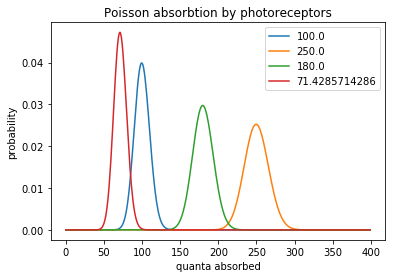

In [220]:
n_absorbed = np.arange(0, 400) # poisson process must have integer evaluations only!
for i in range(4):
    plt.plot(n_absorbed, poisson.pmf(n_absorbed, norm_absorb[i]));
plt.legend(norm_absorb);
plt.xlabel('quanta absorbed');
plt.ylabel('probability');
plt.title('Poisson absorbtion by photoreceptors');

#### Checking the convolution calculation

Let's try something other than a point-source for light

In [233]:
# for creating luminance signal - gaussian
x_eval = np.linspace(x_min, x_max, n_pts)
y_eval = np.linspace(y_min, y_max, n_pts)
xy_eval = np.meshgrid(x_eval, y_eval)
xy_arr = np.asarray(xy_eval);

lum = 3; # in cd/m2
lum_sigma = 75;
lum_signal = lum * hf.gauss_2d((xy_arr[0], xy_arr[1]), 1, lum_sigma)
# absolute values likely not right...

absorb_curr, conv2d_curr = hf.absorb(lum_signal, psf); # default

Note the edge artifacts! The receptor is a hard-edge...

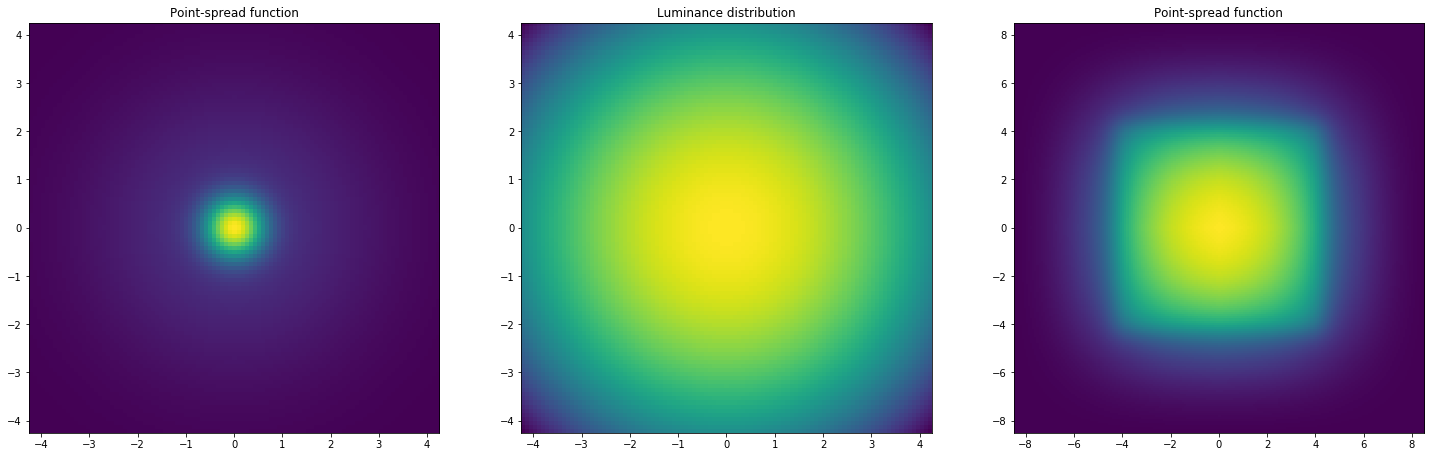

In [232]:
f, ax = plt.subplots(1, 3, figsize=(25, 10))

ax[0].imshow(psf, extent=[np.min(x_eval), np.max(x_eval), np.min(y_eval), np.max(y_eval)], cmap='viridis');
ax[0].set_title('Point-spread function');

ax[1].imshow(lum_signal, extent=[np.min(x_eval), np.max(x_eval), np.min(y_eval), np.max(y_eval)], cmap='viridis');
ax[1].set_title('Luminance distribution');

ax[2].imshow(conv2d_curr, extent=[2*np.min(x_eval), 2*np.max(x_eval), 2*np.min(y_eval), 2*np.max(y_eval)], cmap='viridis');
ax[2].set_title('Point-spread function');

In [252]:
# for creating luminance signal - edge
lum_signal = np.ones((25, 25));
lum_signal[:, 0:13] = 0

absorb_curr, conv2d_curr = hf.absorb(lum_signal, psf); # default

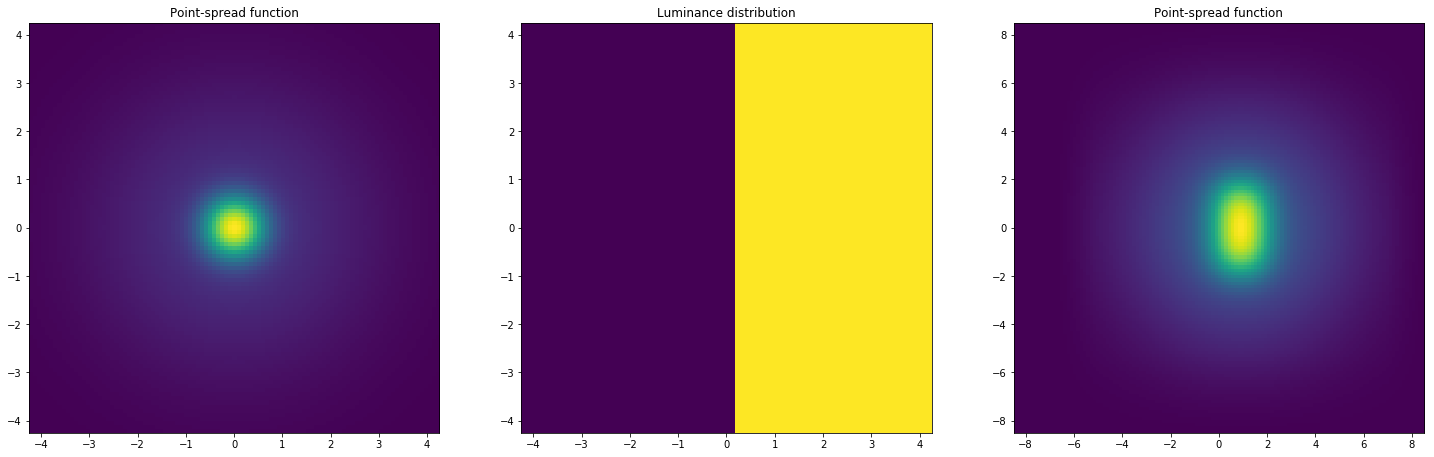

In [253]:
f, ax = plt.subplots(1, 3, figsize=(25, 10))

ax[0].imshow(psf, extent=[np.min(x_eval), np.max(x_eval), np.min(y_eval), np.max(y_eval)], cmap='viridis');
ax[0].set_title('Point-spread function');

ax[1].imshow(lum_signal, extent=[np.min(x_eval), np.max(x_eval), np.min(y_eval), np.max(y_eval)], cmap='viridis');
ax[1].set_title('Luminance distribution');

ax[2].imshow(conv2d_curr, extent=[2*np.min(x_eval), 2*np.max(x_eval), 2*np.min(y_eval), 2*np.max(y_eval)], cmap='viridis');
ax[2].set_title('Point-spread function');